In [102]:
import torch
from torch import nn
from torch.utils.data import DataLoader

from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt

import numpy as np

from collections import namedtuple

from sklearn.metrics import classification_report

In [103]:
train_dataset_path = './DATA_CHAMBER_2021/train'
test_dataset_path = './DATA_CHAMBER_2021/test'

In [104]:
train_transforms = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.ToTensor()
])

In [105]:
train_dataset = torchvision.datasets.ImageFolder(root = train_dataset_path, transform=train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root = test_dataset_path, transform=test_transforms)

In [106]:
def show_transformed_images(dataset):
    loader = DataLoader(dataset, batch_size = 6, shuffle = True)
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images, nrow = 3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid,(1,2,0)))
    print('label: ', labels)

label:  tensor([0, 2, 2, 2, 1, 1])


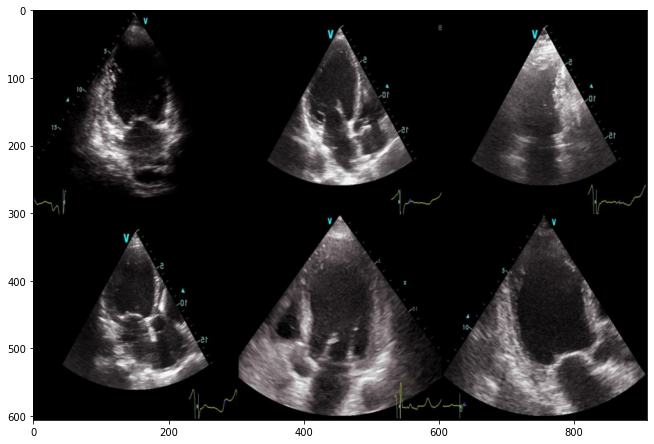

In [107]:
show_transformed_images(train_dataset)

In [108]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [109]:
def set_device():
    if torch.cuda.is_available():
        dev = "cuda:0"
    else:
        dev = "cpu"
    return torch.device(dev)

In [110]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    device = set_device()
    
    for epoch in range(n_epochs):
        print("epoch number %d" % (epoch + 1))
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0
        
        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            
            loss = criterion(outputs, labels)
            
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()
        
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100.00 * running_correct / total
        
        print("   - Training dataset. Got %d out of %d images correctly(%.3f%%). Epoch loss: %.3f" % (running_correct, total, epoch_acc, epoch_loss))
        
        evaluate_model_on_test_set(model, test_loader)
        
        print("Finished")
        return model

In [111]:
def evaluate_model_on_test_set(model, test_loader):
    model.eval()
    predicted_correctly_on_epoch = 0
    total = 0
    device = set_device()
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            
            predicted_correctly_on_epoch += (predicted == labels).sum().item()
            
    epoch_acc = 100.0 * predicted_correctly_on_epoch/total
    print("    - Testing dataset. Got %d out of %d images correctly (%.3f%%)" % (predicted_correctly_on_epoch, total, epoch_acc))
            

In [112]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

resnet18_model = models.resnet18(pretrained=False)
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 3
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
device = set_device()
resnet_18_model = resnet18_model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)

In [113]:
train_nn(resnet18_model, train_loader, test_loader, loss_fn, optimizer, 150)

epoch number 1
   - Training dataset. Got 4699 out of 6717 images correctly(69.957%). Epoch loss: 0.681
    - Testing dataset. Got 679 out of 1607 images correctly (42.253%)
Finished


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  